based on http://cs231n.github.io/understanding-cnn/

In [2]:
import cv2
import os
import numpy as np
np.random.seed(123)
import tensorflow as tf
tf.set_random_seed(123)
from keras import backend as K
from fcnnmodel import cnnModel
K.set_learning_phase(0)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import matplotlib.pyplot as plt

In [4]:
% matplotlib inline

load the trained model

In [5]:
model = cnnModel((48, 48, 3), 4)
model.load_weights('./weightsoef.hdf5')

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 64)          0         
__________

get all the weights from the trained model

In [7]:
weights_list = model.get_weights()

In [8]:
len(weights_list)

10

In [9]:
for index in range(len(weights_list)):
    print weights_list[index].shape

(3, 3, 3, 32)
(32,)
(3, 3, 32, 32)
(32,)
(3, 3, 32, 64)
(64,)
(4, 4, 64, 64)
(64,)
(1, 1, 64, 4)
(4,)


In [10]:
from keras import Model
from matplotlib import colors

class visualize_cnn:
    def __init__(self, model):
        self.model = model
        self.__find_kernel_index__()
        
    # find the kernel index in the model.get_weights() list
    def __find_kernel_index__(self):
        # weights_lst has kernel value and bias value.
        # the length of this list = 2 * num of conv_layers
        self.weights_lst = self.model.get_weights()
        self.convlayer_index_lst = []
        self.num_kernels_lst = []
        print "all the conv layers weights shape"
        for index in range(len(self.weights_lst)):
            weights_shape = self.weights_lst[index].shape
            # make sure it is not the bias in CNN
            if len(weights_shape) != 1:
                print weights_shape
                num_kernels = weights_shape[-1]
                self.convlayer_index_lst += [index]
                self.num_kernels_lst += [num_kernels]
        #print self.convlayer_index_lst
        #print self.num_kernels_lst
    
    def visualize_kernels(self, convlayer_index):
        weight_index = convlayer_index - 1
        kernel_weights = self.weights_lst[self.convlayer_index_lst[weight_index]]
        num_kernels = self.num_kernels_lst[weight_index]
        #print kernel_weights.shape, num_kernels
        if kernel_weights.shape[-2] != 3:
            print "kernel channel larger than 3, no visualization"
            return None
        if num_kernels > 8:
            num_rows = 8
            num_columns = num_kernels/8
            kernel_index = 0
            fig, axes = plt.subplots(num_rows, num_columns, figsize=(8,8))
            for row in range(num_rows):
                for column in range(num_columns):
                    #print kernel_weights[:,:,:,kernel_index].shape
                    visual_kernel = kernel_weights[:,:,:,kernel_index].reshape(3,3,3)
                    axes[row, column].imshow(visual_kernel)
                    axes[row, column].axis('off')
                    kernel_index += 1
        else:
            num_rows = num_kernels
            kernel_index = 0
            fig, axes = plt.subplots(num_rows, figsize=(16, 16))
            for row in range(num_rows):
                visual_kernel = kernel_weights[:,:,:,kernel_index].reshape(3,3,3)
                axes[row].imshow(visual_kernel)
                axes[row].axis('off')
                kernel_index += 1
        
    def visualize_activation(self, input_image, convlayer_index, save_name):
        weight_index = convlayer_index - 1
        image_width = input_image.shape[0]
        image_height = input_image.shape[1]
        channel = 3
        input_image_reshaped = input_image.reshape(1, image_width, image_height, channel)
        
        layer_name = "conv2d_" + str(convlayer_index)
        num_kernels = self.num_kernels_lst[weight_index]
        print "name of current layer: ", layer_name
        print "num of kernels in current layer: ", num_kernels

        intermediate_layer_model = Model(inputs=model.input, outputs=self.model.get_layer(layer_name).output)
        intermediate_output = intermediate_layer_model.predict(input_image_reshaped)
        # print intermediate_output.shape
        output_widht = intermediate_output.shape[1]
        output_height = intermediate_output.shape[2]
        reshaped_output = intermediate_output.reshape(output_widht, output_height, -1)
        print "output of current layer: ", reshaped_output.shape
        if num_kernels > 8:
            num_rows = 8
            num_columns = num_kernels/8
            kernel_index = 0
            fig, axes = plt.subplots(num_rows, num_columns, figsize=(16, 16))
            fig.suptitle(save_name + "\n" + 
                        "name of current layer: " + layer_name + "\n" + 
                         "num of kernels in current layer: " + str(num_kernels) + "\n" +
                         "output shape: " + str(reshaped_output.shape)
                        )
            images = []
            for row in range(num_rows):
                for column in range(num_columns):
                    if convlayer_index != 4:
                        im = axes[row, column].imshow(reshaped_output[:,:,kernel_index], cmap="gray")
                        axes[row, column].axis('off')
                        fig.colorbar(im, ax= axes[row, column])
                    else:
                        axes[row, column].axis('off')
                        images.append(axes[row, column].imshow(reshaped_output[:,:,kernel_index], cmap="gray"))
                        vmin = min(image.get_array().min() for image in images)
                        vmax = max(image.get_array().max() for image in images)
                        norm = colors.Normalize(vmin=vmin, vmax=vmax)
                        for im in images:
                            im.set_norm(norm)
                        fig.subplots_adjust(right=0.8)
                        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
                        fig.colorbar(im, cax=cbar_ax)
                    kernel_index += 1
            fig.savefig(save_name + ".jpeg")
        else:
            num_rows = num_kernels
            kernel_index = 0
            fig, axes = plt.subplots(num_rows, figsize=(16, 16))
            fig.suptitle(save_name + "\n" + 
                        "name of current layer: " + layer_name + "\n" + 
                         "num of kernels in current layer: " + str(num_kernels) + "\n" +
                         "output shape: " + str(reshaped_output.shape)
                        )
            for row in range(num_rows):
                im = axes[row].imshow(reshaped_output[:,:,kernel_index], cmap="gray")
                axes[row].axis("off")
                kernel_index = +1
            fig.subplots_adjust(right=0.8)
            cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
            fig.colorbar(im, cax=cbar_ax)
            fig.savefig(save_name + ".jpeg")

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 64)          0         
__________

In [12]:
visualizer = visualize_cnn(model)

all the conv layers weights shape
(3, 3, 3, 32)
(3, 3, 32, 32)
(3, 3, 32, 64)
(4, 4, 64, 64)
(1, 1, 64, 4)


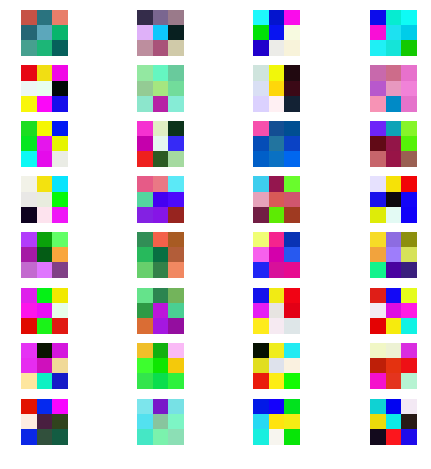

In [13]:
convlayer_index = 1
visualizer.visualize_kernels(convlayer_index)

In [14]:
file_path_dict = {
    "TP_tractor":"./Images/TP/DSC07407_1534411226516.JPG",
    "TP_red_car":"./Images/TP/DSC07578_1534411226516.JPG",
    "TP_car_left":"./Images/another_dataset/00001007_co.png",
    "TP_car_right":"./Images/another_dataset/00001007_co.png",
    "TP_background":"./Images/another_dataset/00001007_co.png",
    "FN_black_car":"./Images/FN/DSC07867_1534411226516.JPG"
}

In [15]:
left_top_index_dict = {
    "TP_tractor":[340, 205],
    "TP_red_car":[265, 650],
    "TP_car_left":[350, 420],
    "TP_car_right":[340, 460],
    "TP_background":[400, 600],
    "FN_black_car":[85, 330]
}

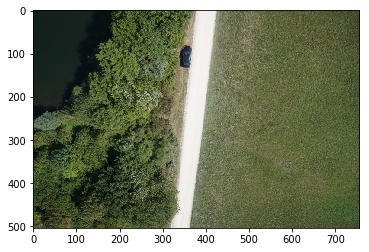

In [16]:
key = "FN_black_car"
file_path = file_path_dict[key]
example_image = plt.imread(file_path)
resized_image = cv2.resize(example_image, (756, 504), interpolation = cv2.INTER_AREA)
plt.imshow(resized_image)

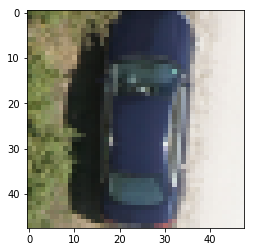

In [17]:
save_name = key + "_original"
row_index = left_top_index_dict[key][0]
column_index = left_top_index_dict[key][1]
size = 48

example_cropped_image = resized_image[row_index:row_index + size, column_index:column_index+size]
plt.imshow(example_cropped_image)
plt.imsave(save_name + ".jpeg", example_cropped_image)

name of current layer:  conv2d_1
num of kernels in current layer:  32
output of current layer:  (46, 46, 32)


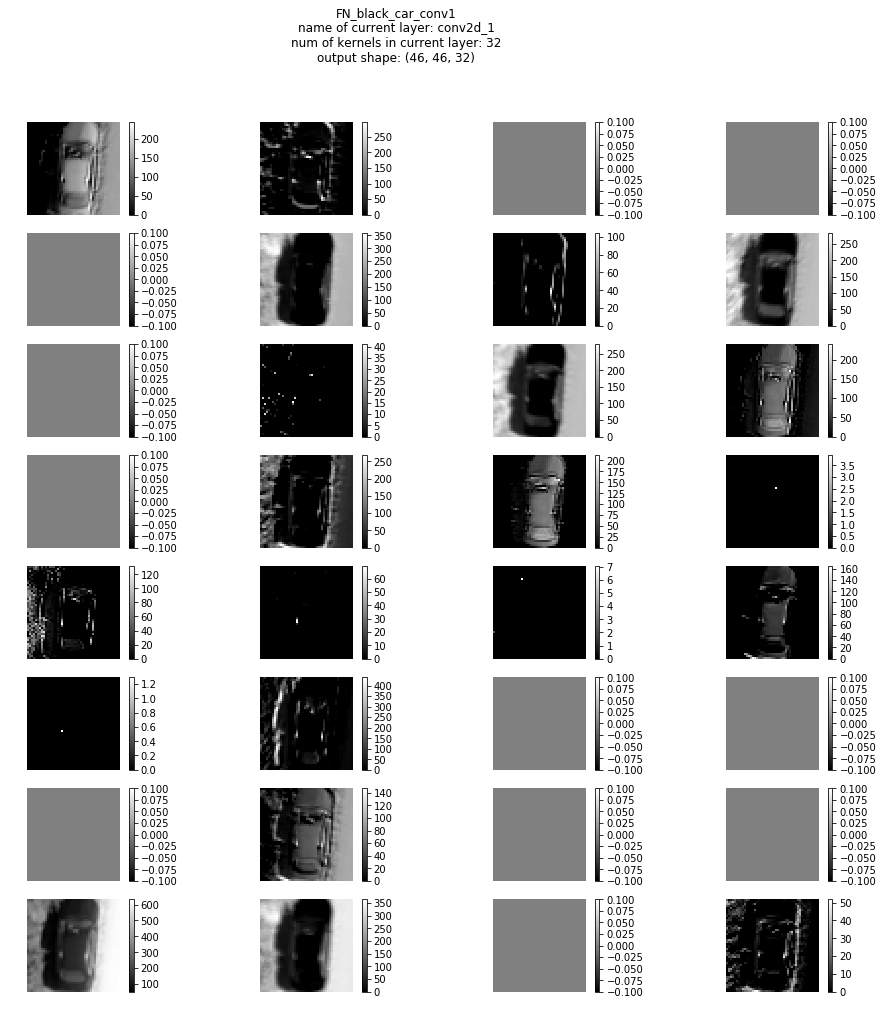

In [18]:
convlayer_index = 1
save_name = key + "_conv"+ str(convlayer_index)
visualizer.visualize_activation(example_cropped_image, convlayer_index, save_name)

name of current layer:  conv2d_2
num of kernels in current layer:  32
output of current layer:  (23, 23, 32)


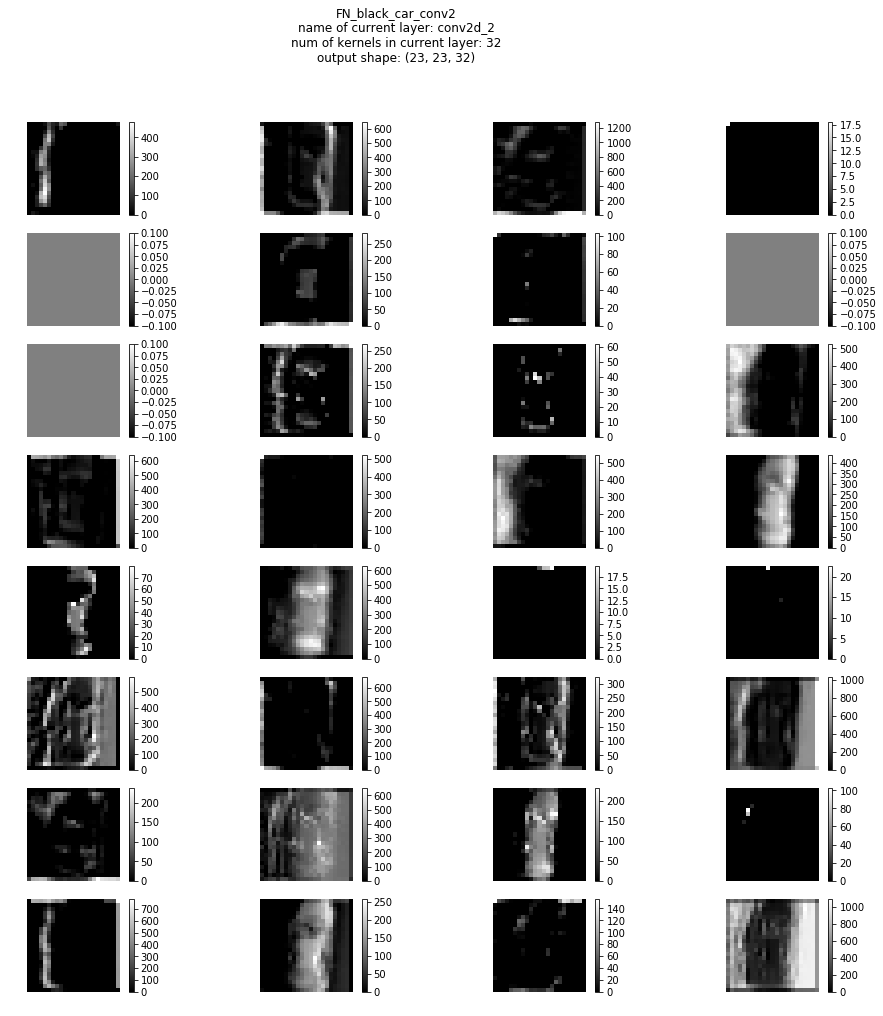

In [19]:
convlayer_index = 2
save_name = key + "_conv"+ str(convlayer_index)
visualizer.visualize_activation(example_cropped_image, convlayer_index, save_name)

name of current layer:  conv2d_3
num of kernels in current layer:  64
output of current layer:  (9, 9, 64)


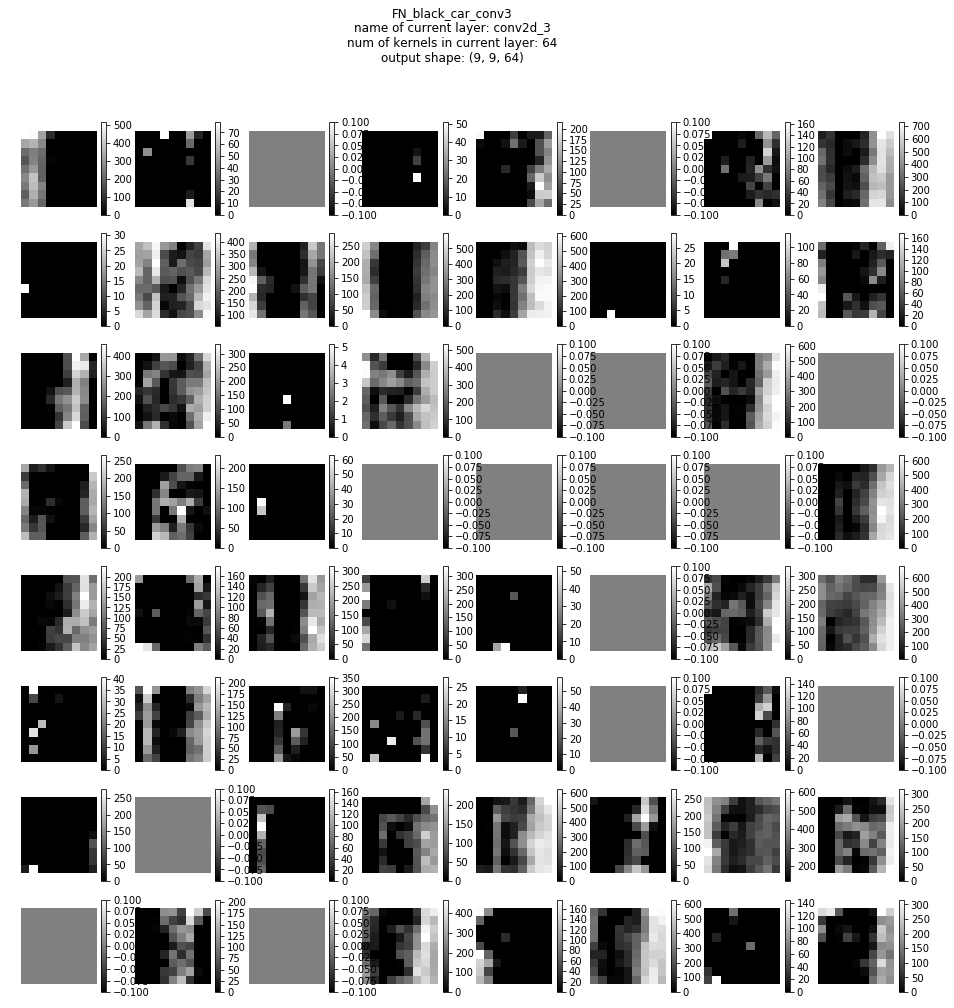

In [20]:
convlayer_index = 3
save_name = key + "_conv"+ str(convlayer_index)
visualizer.visualize_activation(example_cropped_image, convlayer_index, save_name)

name of current layer:  conv2d_4
num of kernels in current layer:  64
output of current layer:  (1, 1, 64)


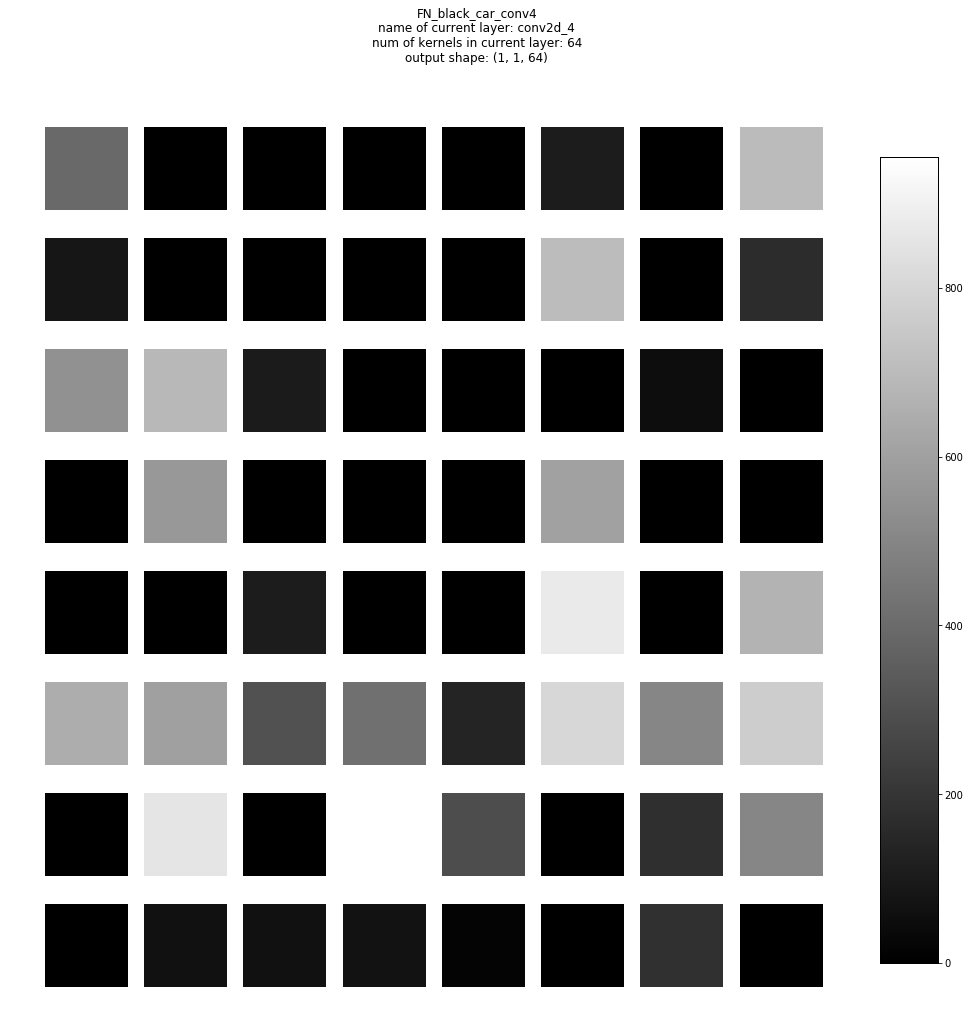

In [21]:
convlayer_index = 4
save_name = key + "_conv"+ str(convlayer_index)
visualizer.visualize_activation(example_cropped_image, convlayer_index, save_name)

In [22]:
np.argmax(model.predict(example_cropped_image.reshape(1, 48, 48, 3)))

3

In [23]:
convlayer_index = 5
layer_name = "conv2d_" + str(convlayer_index)
#num_kernels = num_kernels_lst[weight_index]
#print "name of current layer: ", layer_name
#print "num of kernels in current layer: ", num_kernels

intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(example_cropped_image.reshape(1, 48, 48, 3))
print np.argmax(intermediate_output)
print intermediate_output.shape
print intermediate_output

3
(1, 1, 1, 4)
[[[[0. 0. 0. 1.]]]]
